
[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Enter stock ticker (e.g. AAPL, TSLA, MSFT):  AAPL
Enter start date (YYYY-MM-DD):  2024-01-01
Enter end date (YYYY-MM-DD):  2025-01-01



Fetching data for AAPL from 2024-01-01 to 2025-01-01 ...

=== SUMMARY ===
Start Price: 183.90
End Price: 249.29
Cumulative Return: 35.56%
Annualized Return: 39.14%
Annualized Volatility: 22.42%
Sharpe-like Ratio: 1.75

=== INSIGHTS ===
📈 Price is above the 50-day MA → bullish trend
🙂 RSI 54.0 → Neutral
🚨 MACD below Signal → Bearish momentum


/tmp/ipykernel_88353/3536115073.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


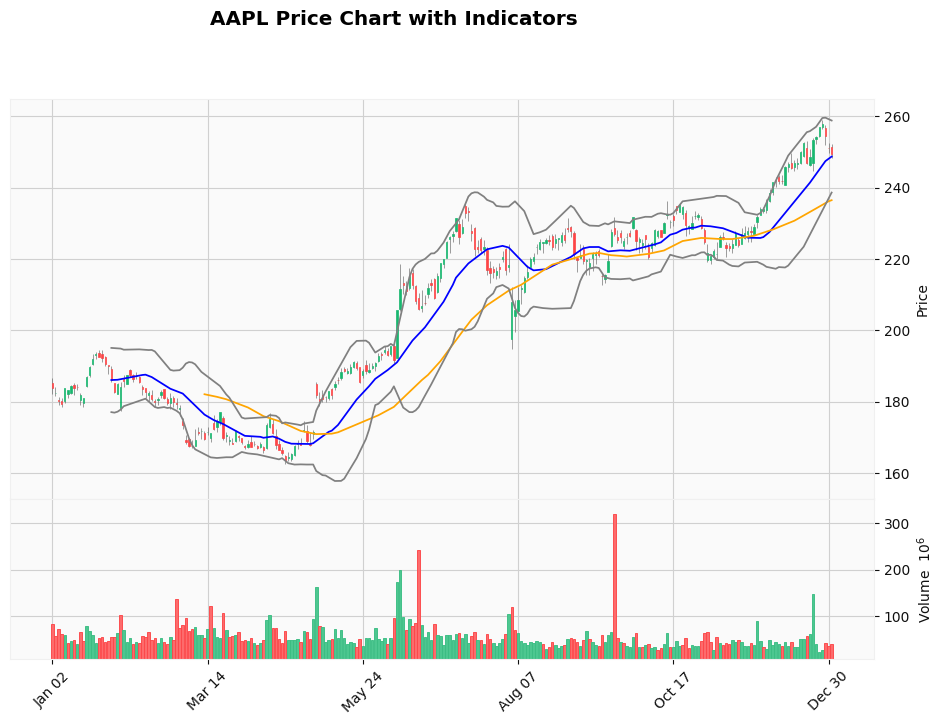

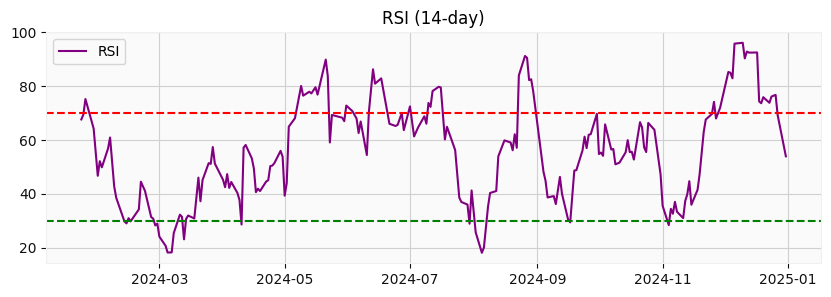

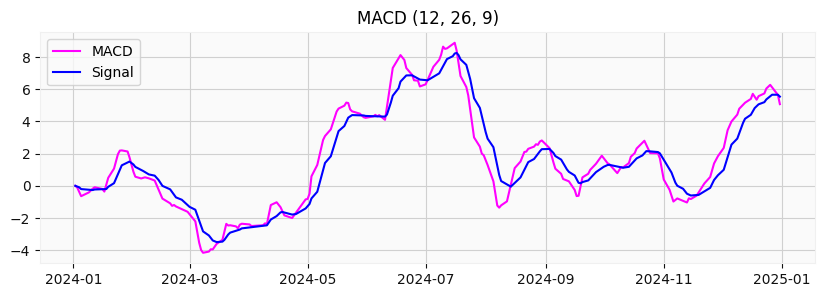

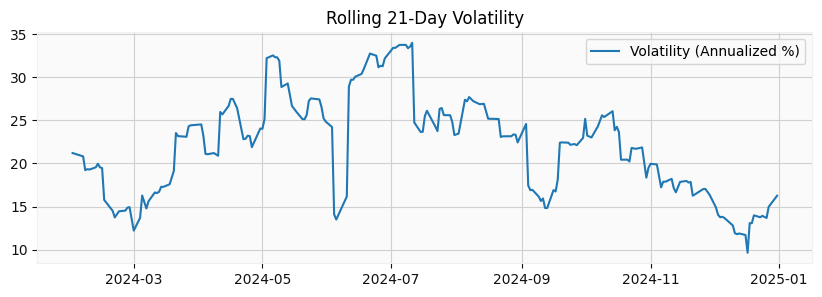


✅ Analysis Complete.


In [3]:
# ===============================================================
# 📈 Advanced Stock Price Tracker (Fixed & Stable for Jupyter)
# ===============================================================

!pip install yfinance mplfinance pandas numpy matplotlib -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta

# ---------------------------------------------------------------
# USER INPUTS
# ---------------------------------------------------------------
ticker = input("Enter stock ticker (e.g. AAPL, TSLA, MSFT): ").upper().strip()
if ticker == "":
    ticker = "AAPL"

start_date = input("Enter start date (YYYY-MM-DD): ") or "2023-01-01"
end_date = input("Enter end date (YYYY-MM-DD): ") or datetime.today().strftime('%Y-%m-%d')

# ---------------------------------------------------------------
# FETCH DATA
# ---------------------------------------------------------------
print(f"\nFetching data for {ticker} from {start_date} to {end_date} ...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# ✅ Fix for multi-level columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# ✅ Ensure we only have OHLCV columns
expected_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
data = data[[c for c in expected_cols if c in data.columns]]

if data.empty:
    raise ValueError("No data returned. Check the ticker or date range.")

data.dropna(inplace=True)

# ---------------------------------------------------------------
# INDICATOR CALCULATIONS
# ---------------------------------------------------------------

# Moving Averages
data['MA20'] = data['Close'].rolling(20).mean()
data['MA50'] = data['Close'].rolling(50).mean()

# RSI
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -1 * delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema12 - ema26
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# ✅ Bollinger Bands (ensure Series math)
mid = data['Close'].rolling(20).mean()
std = data['Close'].rolling(20).std()
data['BB_Mid'] = mid
data['BB_Upper'] = mid + 2 * std
data['BB_Lower'] = mid - 2 * std

# Daily returns and volatility
data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(21).std() * np.sqrt(252)

# ---------------------------------------------------------------
# SUMMARY STATISTICS
# ---------------------------------------------------------------
start_price = data['Close'].iloc[0]
end_price = data['Close'].iloc[-1]
cum_return = (end_price / start_price - 1) * 100
annual_return = ((1 + data['Return'].mean()) ** 252 - 1) * 100
annual_vol = data['Return'].std() * np.sqrt(252) * 100
sharpe_ratio = annual_return / (annual_vol + 1e-9)

print("\n=== SUMMARY ===")
print(f"Start Price: {start_price:.2f}")
print(f"End Price: {end_price:.2f}")
print(f"Cumulative Return: {cum_return:.2f}%")
print(f"Annualized Return: {annual_return:.2f}%")
print(f"Annualized Volatility: {annual_vol:.2f}%")
print(f"Sharpe-like Ratio: {sharpe_ratio:.2f}")

# ---------------------------------------------------------------
# ALERTS / INSIGHTS
# ---------------------------------------------------------------
print("\n=== INSIGHTS ===")
latest = data.iloc[-1]
if latest['Close'] > latest['MA50']:
    print("📈 Price is above the 50-day MA → bullish trend")
else:
    print("📉 Price is below the 50-day MA → bearish trend")

if latest['RSI'] > 70:
    print(f"⚠️ RSI {latest['RSI']:.1f} → Overbought")
elif latest['RSI'] < 30:
    print(f"💰 RSI {latest['RSI']:.1f} → Oversold")
else:
    print(f"🙂 RSI {latest['RSI']:.1f} → Neutral")

if latest['MACD'] > latest['Signal']:
    print("✅ MACD above Signal → Bullish momentum")
else:
    print("🚨 MACD below Signal → Bearish momentum")

# ---------------------------------------------------------------
# VISUALIZATIONS
# ---------------------------------------------------------------
plt.style.use("ggplot")

# 1️⃣ Candlestick with MAs and Bollinger Bands
apds = [
    mpf.make_addplot(data['MA20'], color='blue'),
    mpf.make_addplot(data['MA50'], color='orange'),
    mpf.make_addplot(data['BB_Upper'], color='gray'),
    mpf.make_addplot(data['BB_Lower'], color='gray')
]
mpf.plot(data, type='candle', style='yahoo', addplot=apds,
         title=f"{ticker} Price Chart with Indicators",
         volume=True, figsize=(12,8))

# 2️⃣ RSI
plt.figure(figsize=(10,3))
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI (14-day)')
plt.legend()
plt.show()

# 3️⃣ MACD
plt.figure(figsize=(10,3))
plt.plot(data['MACD'], label='MACD', color='magenta')
plt.plot(data['Signal'], label='Signal', color='blue')
plt.title('MACD (12, 26, 9)')
plt.legend()
plt.show()

# 4️⃣ Volatility
plt.figure(figsize=(10,3))
plt.plot(data['Volatility'] * 100, label='Volatility (Annualized %)')
plt.title('Rolling 21-Day Volatility')
plt.legend()
plt.show()

print("\n✅ Analysis Complete.")
